This code is based on:

Jupyter Notebook: Testbench - Image 3D Tests


In [384]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import ipywidgets as widgets
import pydicom as pdicom
import os
import glob
import copy
import open3d as o3d
import scipy.ndimage

from matplotlib import colors as mcolors
from mpl_toolkits.axes_grid1 import ImageGrid
from skimage.segmentation import clear_border
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import disk, dilation, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.filters import roberts, sobel
from scipy import ndimage as ndi
from open3d import JVisualizer

%matplotlib inline

### Helper printing functions

`plti` - plots the provided image.  
`sample_stack` - plots every x slice of a 3D image stack  
`pltm` - creates a simple two column grid of the provided images  
`pltHist` - prints a histogram from the provided image or stack. Defaults to labeling as Hounsfield units

In [385]:
def plti(im, h=8, title='',cmap='gray',**kwargs):
    y = im.shape[0]
    x = im.shape[1]
    w = (y/x) * h
    plt.figure(figsize=(w,h))
    plt.imshow(im, interpolation="none",cmap=cmap, **kwargs)
    plt.axis('off')
    plt.title(title)
    

In [386]:
def sample_stack(stack, rows=6, cols=6, start_with=10, show_every=3, size=12,cmap='gray'):
    fig,ax = plt.subplots(rows,cols,figsize=[size,size])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        if ind < stack.shape[2]:
            ax[int(i/cols),int(i % cols)].set_title('slice %d' % ind)
            ax[int(i/cols),int(i % cols)].imshow(stack[:,:,ind],cmap)
            ax[int(i/cols),int(i % cols)].axis('off')
    plt.show()

In [387]:
def pltm(images,h=8,titles=[],cmap='gray'):
    
    imNum = len(images)
    imX   = (imNum+1)//2
    
    y = images[1].shape[0]
    x = images[1].shape[1]
    w = (y/x) * h
    
    fig = plt.figure(figsize=(w,h))
    grid = ImageGrid(fig, 111,             # similar to subplot(111)
                     nrows_ncols=(imX, 2), # creates 2x2 grid of axes
                     axes_pad=0.25,           # pad between axes in inch.
                     )

    for i in range(imNum):
        grid[i].imshow(images[i],cmap=cmap)  # The AxesGrid object work as a list of axes.
        grid[i].axis('off')
        grid[i].set_xticks([])
        grid[i].set_yticks([])
        if len(titles) > i :
            grid[i].set_title(titles[i])  
            
    plt.show()

In [388]:
def pltHist(image, bins=50,xlabel="Hounsfield Units (HU)",ylabel="Frequency", color='c'):

    plt.hist(image.flatten(), bins=bins, color=color)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


### Datafile Reading

This section provides the functions to read in the provided. These routines do the following:  
* Get a list of all the dicom (.dcm) files in the input directory
* Read the dicom header off the first file and save the dimensions and space
* Generate a matrix of each pixel's distance from 0, 0, 0 based in the dimensions and space obtained from the header
* Read the dicom files (one slice to a file)

In [389]:
INPUT_FOLDER = '/Users/john/Programming/Work/AnnotatedScans/Pat1068Padded'
# INPUT_FOLDER = '/Users/john/Programming/Work/Medtronic Samples/Pat002'
# INPUT_FOLDER = '/Users/john/Programming/Work/patient 1068'


In [390]:
def load_scan2(path):
    
    lstFilesDCM = []

    for dirName, subdirList, fileList in os.walk(path):
        for filename in fileList:
            if ".dcm" in filename.lower():
                lstFilesDCM.append(os.path.join(dirName,filename))
#                 print(lstFilesDCM)

    lstFilesDCM.sort()
    return lstFilesDCM


In [391]:
def GetSpacing(fileList):
    
    RefDs = pdicom.read_file(fileList)

    #Load dimensions based on the number of rows, columns, and slices (along the Z axis)
    ConstPixelDims = np.asarray((int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM)+1))

    #Load spacing values (in mm)
    ConstPixelSpacing = np.asarray((float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness)))

    print('Pixel Dimensions: {}'.format(ConstPixelDims))
    print('Pixel Spacing:    {}'.format(ConstPixelSpacing))

    # print(RefDs.elements)
    
    return ConstPixelDims, ConstPixelSpacing


If you're interested in the measurement from 0,0,0 to any pixel, these arrays will show that. They're not currently used anywhere after this

In [392]:
def GenDimArray(ConstPixelDims, ConstPixelSpacing, doPrint=False):
    
    x = np.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
    y = np.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
    z = np.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])

    if doPrint:
        print(x,y,z)
        
    return x, y, z

In [397]:
def ReadDICOM(ConstPixelDims, lstFilesDCM):

    # The array is sized based on 'ConstPixelDims'

    newDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

    # loop through all the DICOM files
    for filenameDCM in lstFilesDCM:
        # read the file
        ds = pdicom.read_file(filenameDCM)
        # Store the raw image data
        newDicom[:, :, pdicom.read_file(filenameDCM).InstanceNumber] = ds.pixel_array
    
    return newDicom


### Resampling

Use the metadata from the DICOM calculate the size of each voxel as the slice thickness and resampled into 1x1x1 mm pixels and slices.  

NOTE: When finished, the slices are normalized by subtracting off the min value of the entire stack (typically -1000)

In [399]:
def resample(image, spacing, new_spacing=[1,1,1]):

    resize_factor = new_spacing / spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

def shiftHouns(image):
    
    minH = np.min(image.flatten())
    image = image - minH
    return(image)


### Read the DICOM

This code sets up the segmentation code that follows by reading in the DICOM file and resizing it to 1 x 1 x 1mm.

Pixel Dimensions: [512 512 410]
Pixel Spacing:    [0.703125 0.703125 0.7     ]
Slice Thickness: 0.700000
Pixel Spacing (row, col): (0.703125, 0.703125) 
Shape before resampling	 (512, 512, 410)
Shape after resampling	 (728, 728, 586)


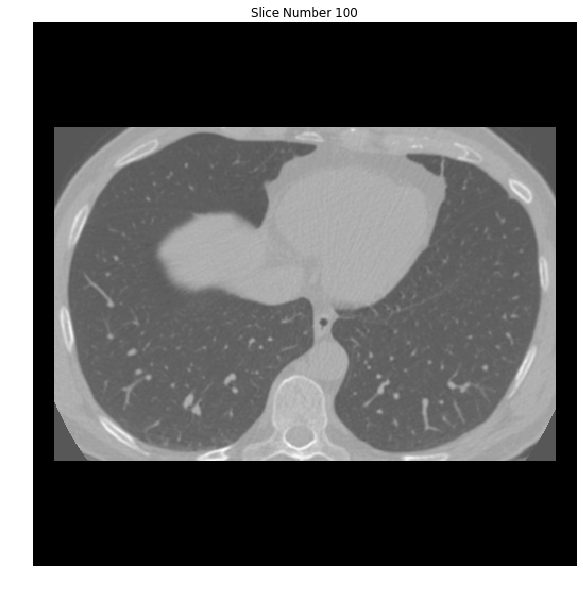

In [401]:
lstFilesDCM = load_scan2(INPUT_FOLDER)
lstFilesDCM.sort()
# print(lstFilesDCM)

GetSpacing(lstFilesDCM[0])
GenDimArray(ConstPixelDims, ConstPixelSpacing, False)

ArrayDicom = ReadDICOM(ConstPixelDims, lstFilesDCM)

sliceNum = 100
plti(ArrayDicom[:, :, sliceNum],10,title = "Slice Number {}".format(sliceNum),cmap='gray')

img_resampled, spacing = resample(ArrayDicom, ConstPixelSpacing, [1,1,1])

print("Slice Thickness: %f" % ConstPixelSpacing[2])
print("Pixel Spacing (row, col): (%f, %f) " % (ConstPixelSpacing[0], ConstPixelSpacing[1]))

print("Shape before resampling\t", ArrayDicom.shape)
print("Shape after resampling\t", img_resampled.shape)

img_resampled = shiftHouns(img_resampled)